In [ ]:
import pandas as pd

# === データ読み込み ===
merged = pd.read_csv("../data/merged/merged_trends_visitors.csv")
merged["Visitor_Arrivals"] = merged["Visitor_Arrivals"].astype(float)

# === 国別に相関を計算 ===
corrs = []
for country, df_c in merged.groupby("Country"):
    if len(df_c) > 10:  # データが少なすぎると相関が安定しない
        r = df_c["trend_interest"].corr(df_c["Visitor_Arrivals"])
        corrs.append({"Country": country, "Correlation": round(r, 3)})

corr_df = pd.DataFrame(corrs).sort_values("Correlation", ascending=False)
print("📊 各国の検索トレンド × 訪日客数の相関係数：\n")
print(corr_df)
corr_df.to_csv("../data/merged/correlation_by_country.csv", index=False, encoding="utf-8-sig")

📊 各国の検索トレンド × 訪日客数の相関係数：

         Country  Correlation
3         Taiwan        0.711
0          China        0.148
5  United States        0.091
2    South Korea        0.034
4       Thailand       -0.115
1      Hong Kong       -0.188


<Figure size 1200x500 with 0 Axes>

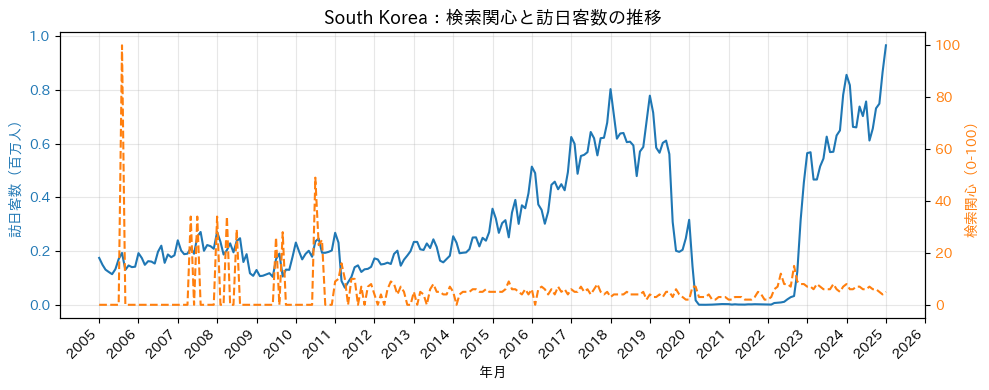

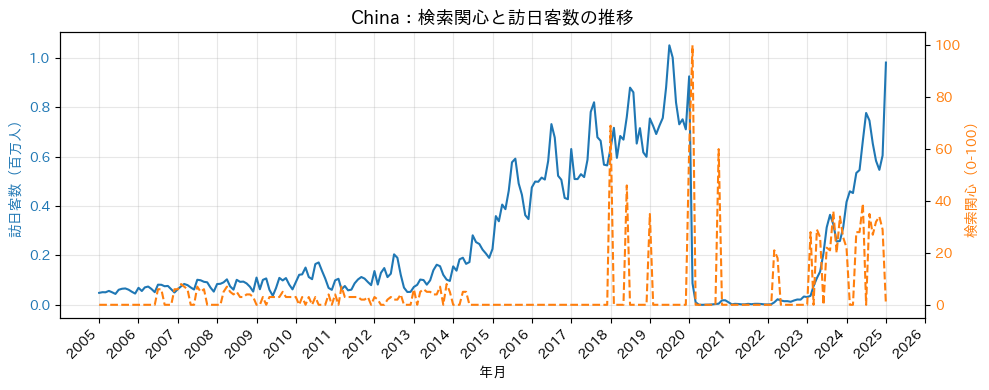

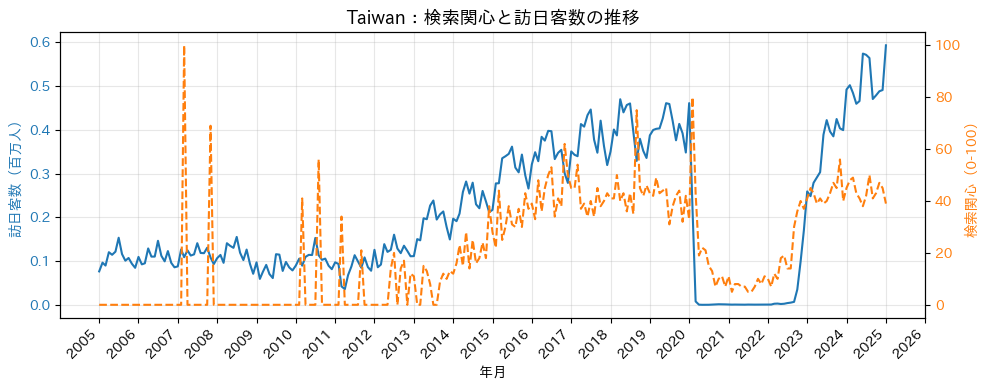

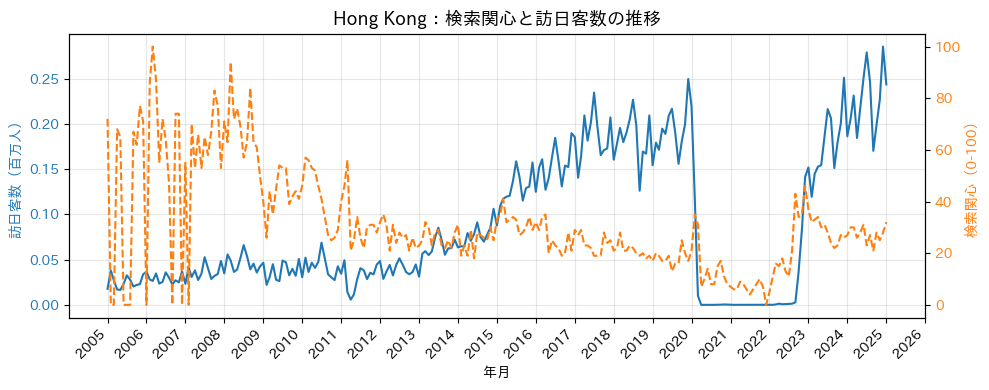

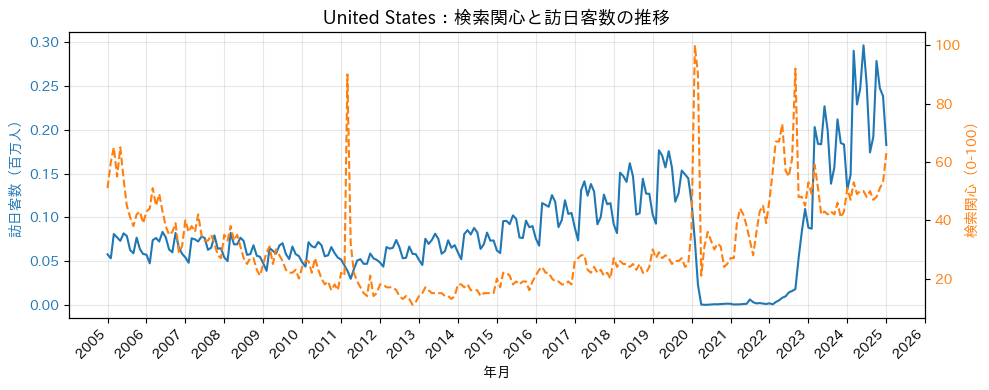

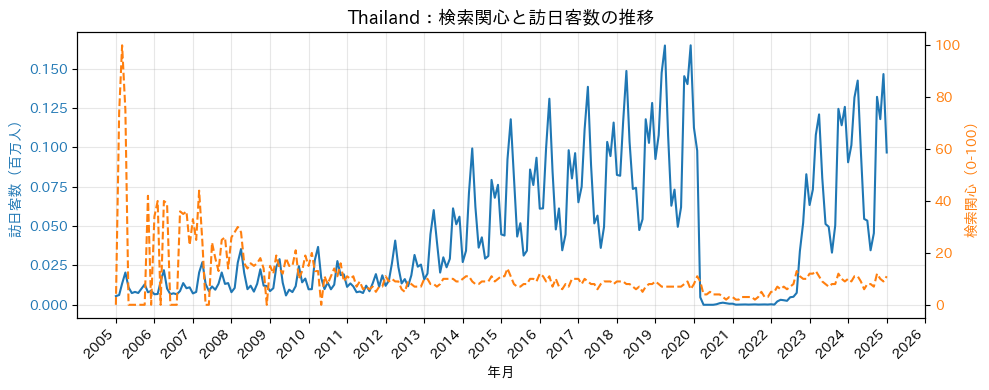

In [11]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import pandas as pd

# === 日付型に変換（ここが重要！） ===
merged["date"] = pd.to_datetime(merged["date"], errors="coerce")  # 不正な値はNaTに

# NaT（欠損）を除去
merged = merged.dropna(subset=["date"])

# === グラフ設定 ===
plt.figure(figsize=(12, 5))
target_countries = ["South Korea", "China", "Taiwan", "Hong Kong", "United States", "Thailand"]

for country in target_countries:
    df_c = merged[merged["Country"] == country]
    if len(df_c) == 0:
        continue

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()

    # 折れ線描画
    ax1.plot(df_c["date"], df_c["Visitor_Arrivals"] / 1e6, color="tab:blue", label="訪日客数（百万人）")
    ax2.plot(df_c["date"], df_c["trend_interest"], color="tab:orange", linestyle="--", label="検索関心（Trends）")

    # === 軸設定 ===
    ax1.set_title(f"{country}：検索関心と訪日客数の推移", fontsize=13)
    ax1.set_xlabel("年月")
    ax1.set_ylabel("訪日客数（百万人）", color="tab:blue")
    ax2.set_ylabel("検索関心（0-100）", color="tab:orange")

    # ✅ X軸を「年単位」に設定
    ax1.xaxis.set_major_locator(mdates.YearLocator(1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # === 装飾 ===
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax1.grid(alpha=0.3)

    fig.tight_layout()
    plt.show()

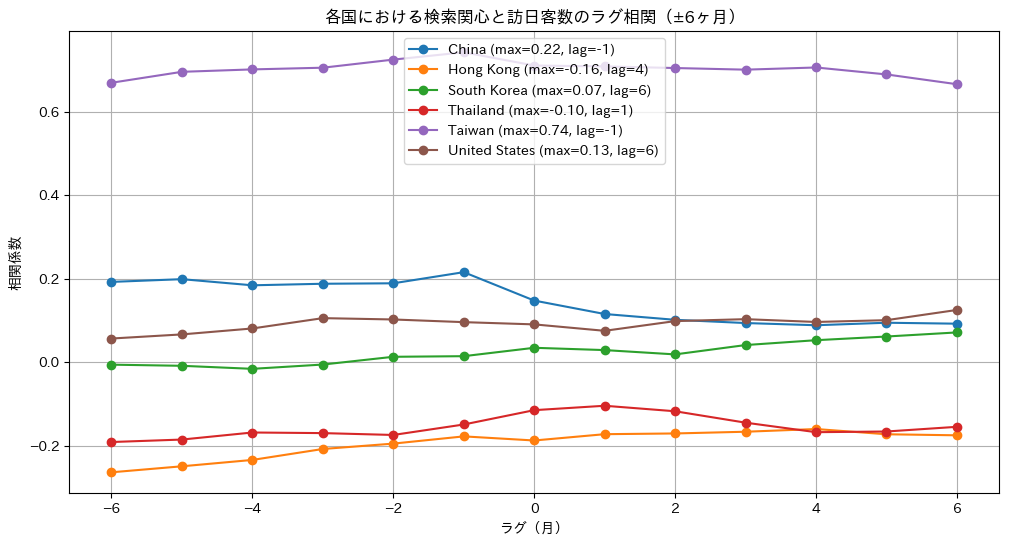

,Country,Best_Lag_Months,Max_Correlation
4,Taiwan,-1,0.742360
0,China,-1,0.215630
5,United States,6,0.125120
2,South Korea,6,0.071265
3,Thailand,1,-0.104419
1,Hong Kong,4,-0.160186


NameError: name 'results_df' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

# データ読込
df = pd.read_csv("../data/merged/merged_trends_visitors.csv")

# 訪日データ（人数）を100万人単位に
df["Visitor_Arrivals"] = df["Visitor_Arrivals"].astype(str).str.replace(",", "").astype(float) / 1e6

countries = df["Country"].unique()
lags = range(-6, 7)  # -6ヶ月〜+6ヶ月

results = []

plt.figure(figsize=(12, 6))
for country in countries:
    sub = df[df["Country"] == country].dropna(subset=["Visitor_Arrivals", "trend_interest"])
    
    corrs = []
    for lag in lags:
        shifted = sub["trend_interest"].shift(lag)
        corr = sub["Visitor_Arrivals"].corr(shifted)
        corrs.append(corr)
    best_lag = lags[np.argmax(corrs)]
    best_corr = max(corrs)
    results.append([country, best_lag, best_corr])
    
    # グラフ描画
    plt.plot(lags, corrs, marker="o", label=f"{country} (max={best_corr:.2f}, lag={best_lag})")

plt.title("各国における検索関心と訪日客数のラグ相関（±6ヶ月）")
plt.xlabel("ラグ（月）")
plt.ylabel("相関係数")
plt.legend()
plt.grid(True)
plt.show()

# 結果まとめ
result_df = pd.DataFrame(results, columns=["Country", "Best_Lag_Months", "Max_Correlation"])
result_df = result_df.sort_values("Max_Correlation", ascending=False)
display(result_df)

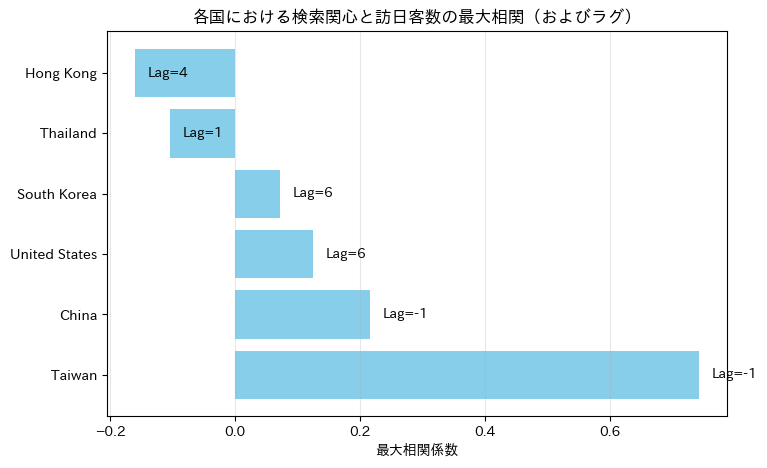

In [22]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(8,5))
plt.barh(result_df["Country"], result_df["Max_Correlation"], color="skyblue")
for i, (lag, corr) in enumerate(zip(result_df["Best_Lag_Months"], result_df["Max_Correlation"])):
    plt.text(corr+0.02, i, f"Lag={lag}", va="center")
plt.xlabel("最大相関係数")
plt.title("各国における検索関心と訪日客数の最大相関（およびラグ）")
plt.grid(axis="x", alpha=0.3)
plt.show()

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/merged/merged_trends_visitors.csv")

countries = df["Country"].unique()
lags = range(-6, 7)  # -6〜+6ヶ月
results = []
all_corrs = []  # ←ここで全ラグ記録用リストを用意

for country in countries:
    sub = df[df["Country"] == country].dropna(subset=["Visitor_Arrivals", "trend_interest"])

    corrs = []
    for lag in lags:
        shifted = sub["trend_interest"].shift(lag)
        corr = sub["Visitor_Arrivals"].corr(shifted)
        corrs.append({"Country": country, "Lag": lag, "Correlation": corr})

    # 最大相関を抜き出し
    best = max(corrs, key=lambda x: x["Correlation"] if pd.notna(x["Correlation"]) else -1)
    results.append({
        "Country": country,
        "Best_Lag_Months": best["Lag"],
        "Max_Correlation": best["Correlation"]
    })

    # 全部まとめる（ヒートマップ用）
    all_corrs.extend(corrs)

# === DataFrame化 ===
results_df = pd.DataFrame(results)
all_corr_df = pd.DataFrame(all_corrs)  # 👈 これが新しく生成されるやつ

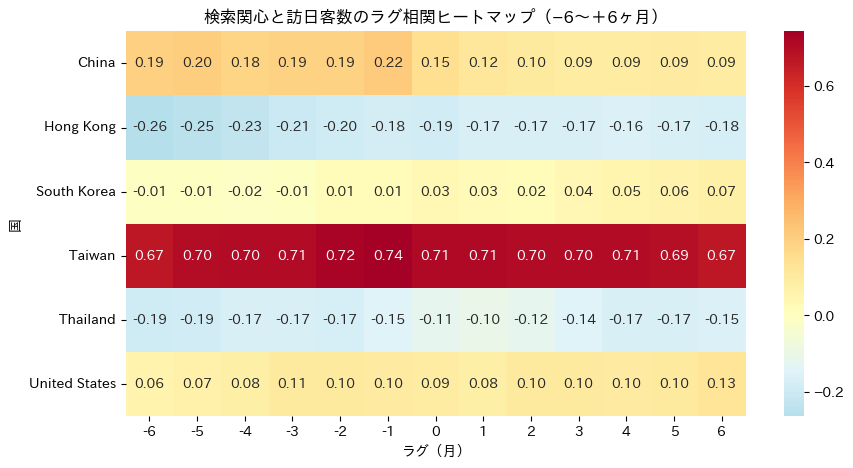

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

heat = pd.pivot_table(all_corr_df, values="Correlation", index="Country", columns="Lag")
plt.figure(figsize=(10,5))
sns.heatmap(heat, cmap="RdYlBu_r", center=0, annot=True, fmt=".2f")
plt.title("検索関心と訪日客数のラグ相関ヒートマップ（−6〜＋6ヶ月）")
plt.xlabel("ラグ（月）")
plt.ylabel("国")
plt.show()

📊 各年のデータ件数（全体）:
date
2005    72
2006    72
2007    72
2008    72
2009    72
2010    72
2011    72
2012    72
2013    72
2014    72
2015    72
2016    72
2017    72
2018    72
2019    72
2020    72
2021    72
2022    72
2023    72
2024    72
2025     6
Name: count, dtype: int64
⏳ South Korea 2018: 12件
⏳ China 2018: 12件
⏳ Taiwan 2018: 12件
⏳ Hong Kong 2018: 12件
⏳ United States 2018: 12件
⏳ Thailand 2018: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2018.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version

⏳ South Korea 2019: 12件
⏳ China 2019: 12件
⏳ Taiwan 2019: 12件
⏳ Hong Kong 2019: 12件
⏳ United States 2019: 12件
⏳ Thailand 2019: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2019.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version

⏳ South Korea 2020: 12件
⏳ China 2020: 12件
⏳ Taiwan 2020: 12件
⏳ Hong Kong 2020: 12件
⏳ United States 2020: 12件
⏳ Thailand 2020: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2020.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direct

⏳ South Korea 2021: 12件
⏳ China 2021: 12件
⏳ Taiwan 2021: 12件
⏳ Hong Kong 2021: 12件
⏳ United States 2021: 12件
⏳ Thailand 2021: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2021.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version

⏳ South Korea 2022: 12件
⏳ China 2022: 12件
⏳ Taiwan 2022: 12件
⏳ Hong Kong 2022: 12件
⏳ United States 2022: 12件
⏳ Thailand 2022: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2022.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version

⏳ South Korea 2023: 12件
⏳ China 2023: 12件
⏳ Taiwan 2023: 12件
⏳ Hong Kong 2023: 12件
⏳ United States 2023: 12件
⏳ Thailand 2023: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2023.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direct

⏳ South Korea 2024: 12件
⏳ China 2024: 12件
⏳ Taiwan 2024: 12件
⏳ Hong Kong 2024: 12件
⏳ United States 2024: 12件
⏳ Thailand 2024: 12件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2024.csv


/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direction="both")
/tmp/ipykernel_37970/3367626658.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  s = s.interpolate(limit_direct

⏳ South Korea 2025: 1件
⏳ China 2025: 1件
⏳ Taiwan 2025: 1件
⏳ Hong Kong 2025: 1件
⏳ United States 2025: 1件
⏳ Thailand 2025: 1件
💾 Saved → ../data/outputs/heatmaps_yearly/lagcorr_2025.csv


/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


✅ lagcorr_2018_2025.csv を保存しました (624 行)
✅ 年別ヒートマップ生成完了！


/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/workspaces/IMetaBearPart2/.venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


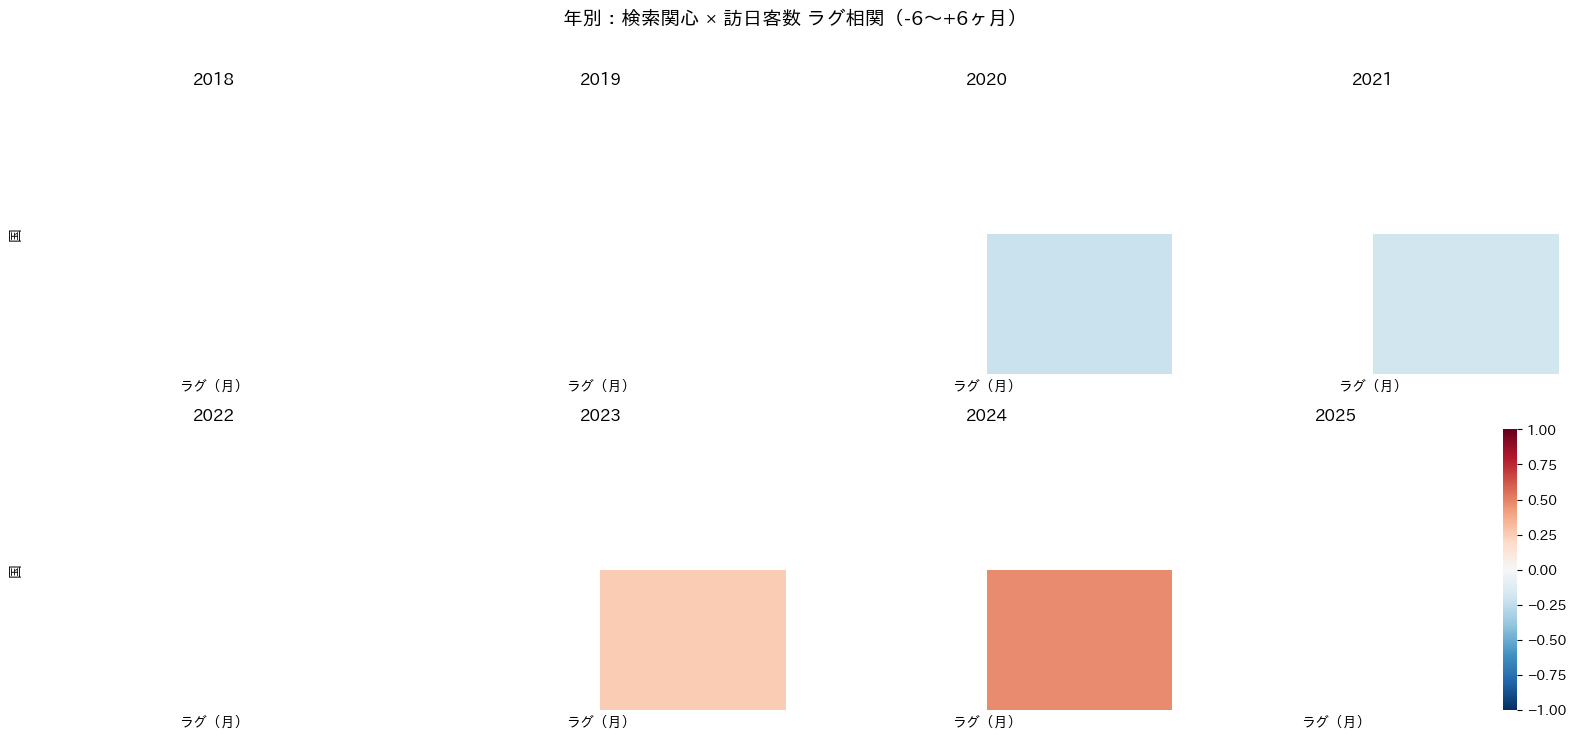

In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# ===== 設定 =====
DATA_PATH = "../data/merged/merged_trends_visitors.csv"
SAVE_DIR  = "../data/outputs/heatmaps_yearly"
os.makedirs(SAVE_DIR, exist_ok=True)

COUNTRIES = ["South Korea", "China", "Taiwan", "Hong Kong", "United States", "Thailand"]
YEARS = list(range(2018, 2026))
LAGS = list(range(-6, 7))

# ===== データ読み込み =====
df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"], errors="coerce")  # ← 強制変換
df = df.sort_values(["Country", "date"])

df["Visitor_Arrivals"] = (
    df["Visitor_Arrivals"].astype(str).str.replace(",", "", regex=False).astype(float)
)
if "trend_interest" not in df.columns:
    if "Trend" in df.columns:
        df = df.rename(columns={"Trend": "trend_interest"})
    else:
        raise ValueError("trend_interest（または Trend）列が見つかりません。")

# ===== 確認：年ごとのデータ件数 =====
print("📊 各年のデータ件数（全体）:")
print(df["date"].dt.year.value_counts().sort_index())

# ===== ラグ相関計算関数 =====
def lagcorr_by_year_country(sub_year_country: pd.DataFrame, lags=LAGS):
    s = sub_year_country.set_index("date").asfreq("MS")
    if s.dropna(subset=["Visitor_Arrivals", "trend_interest"]).shape[0] < 6:
        return {lag: np.nan for lag in lags}

    s = s.interpolate(limit_direction="both")
    out = {}
    for lag in lags:
        out[lag] = s["Visitor_Arrivals"].corr(s["trend_interest"].shift(lag))
    return out

# ===== 年ごとに作成 =====
all_year_dfs = []  # ← ここを追加（全年度をまとめるリスト）

for year in YEARS:
    rows = []
    for country in COUNTRIES:
        sub = df[(df["Country"] == country) & (df["date"].dt.year == year)]
        print(f"⏳ {country} {year}: {len(sub)}件")
        if sub.empty:
            rows.append(pd.DataFrame({
                "Country": country,
                "Lag": LAGS,
                "Correlation": [np.nan] * len(LAGS),
                "Year": year
            }))
            continue

        corr_dict = lagcorr_by_year_country(sub, LAGS)
        rows.append(pd.DataFrame({
            "Country": country,
            "Lag": list(corr_dict.keys()),
            "Correlation": list(corr_dict.values()),
            "Year": year
        }))

    # --- DataFrame統合 ---
    year_df = pd.concat(rows, ignore_index=True)
    all_year_dfs.append(year_df)

    # 💾 年ごとのCSV保存
    year_path = os.path.join(SAVE_DIR, f"lagcorr_{year}.csv")
    year_df.to_csv(year_path, index=False, encoding="utf-8-sig")
    print(f"💾 Saved → {year_path}")

    # --- ヒートマップ作成 ---
    heat = year_df.pivot_table(values="Correlation", index="Country", columns="Lag")
    plt.figure(figsize=(10, 4.8))
    sns.heatmap(heat, annot=True, fmt=".2f", cmap="RdBu_r", center=0, vmin=-1, vmax=1)
    plt.title(f"{year}年：検索関心 × 訪日客数 ラグ相関（-6〜+6ヶ月）")
    plt.xlabel("ラグ（月）")
    plt.ylabel("国")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"heatmap_{year}.png"), dpi=200)
    plt.close()

# ===== 全年分を統合して保存 =====
all_df = pd.concat(all_year_dfs, ignore_index=True)
all_df.to_csv(os.path.join(SAVE_DIR, "lagcorr_2018_2025.csv"), index=False, encoding="utf-8-sig")
print(f"✅ lagcorr_2018_2025.csv を保存しました ({len(all_df)} 行)")
print("✅ 年別ヒートマップ生成完了！")

# ===== まとめ図 =====
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.6*rows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

for i, year in enumerate(YEARS):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    heat = all_year_panels[year]
    sns.heatmap(heat, annot=False, cmap="RdBu_r", center=0, vmin=-1, vmax=1, cbar=(i==len(YEARS)-1), ax=ax)
    ax.set_title(str(year))
    ax.set_xlabel("ラグ（月）")
    if c == 0:
        ax.set_ylabel("国")
    else:
        ax.set_ylabel("")

plt.suptitle("年別：検索関心 × 訪日客数 ラグ相関（-6〜+6ヶ月）", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "heatmap_panel_2018_2025.png"), dpi=180, bbox_inches="tight")
plt.show()

        date  trend_interest Country  Visitor_Arrivals  Year  Lag  Correlation
0 2005-01-01               0   China           48412.0  2005  NaN          NaN
1 2005-02-01               0   China           51101.0  2005  NaN          NaN
2 2005-03-01               0   China           50649.0  2005  NaN          NaN
3 2005-04-01               0   China           56321.0  2005  NaN          NaN
4 2005-05-01               0   China           50721.0  2005  NaN          NaN
South Korea: lag=-1


<Figure size 1200x600 with 0 Axes>

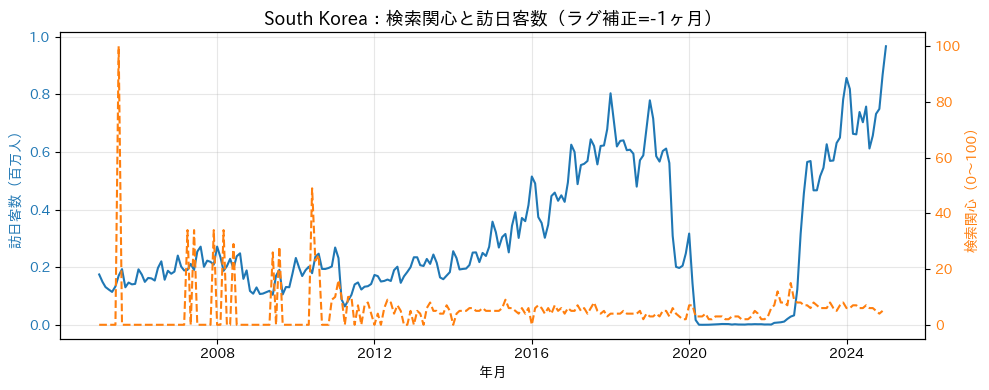

China: lag=0


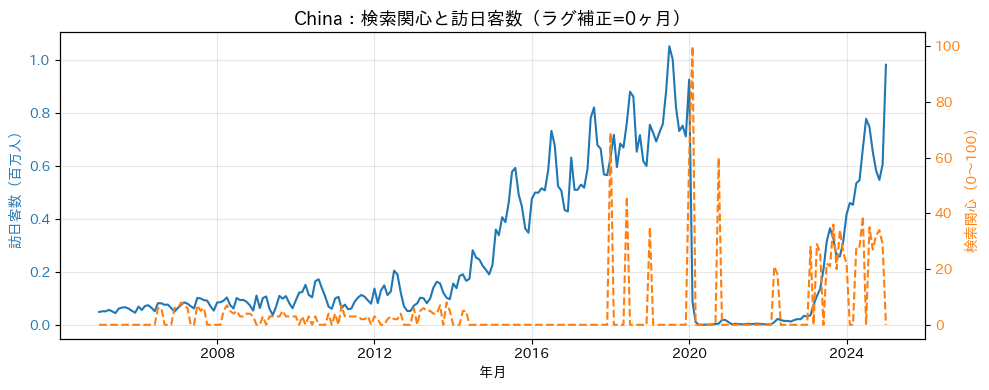

Taiwan: lag=2


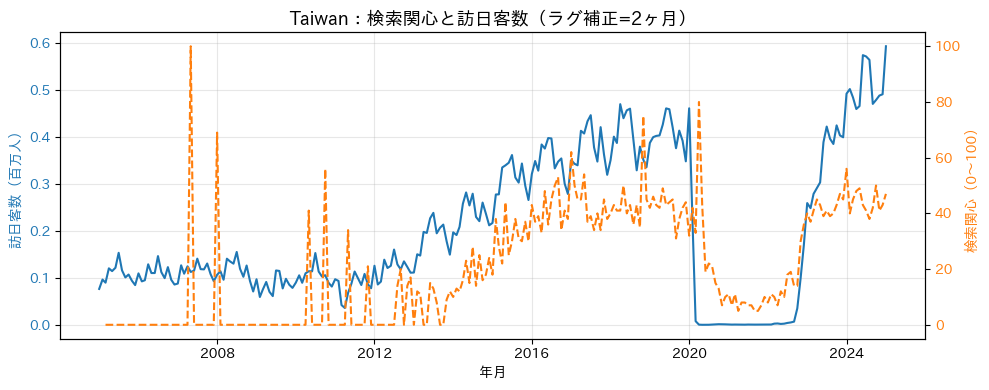

Hong Kong: lag=2


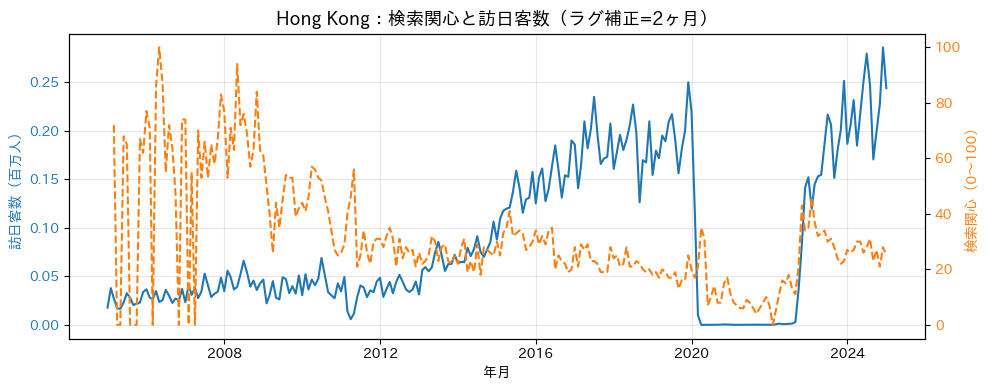

United States: lag=3


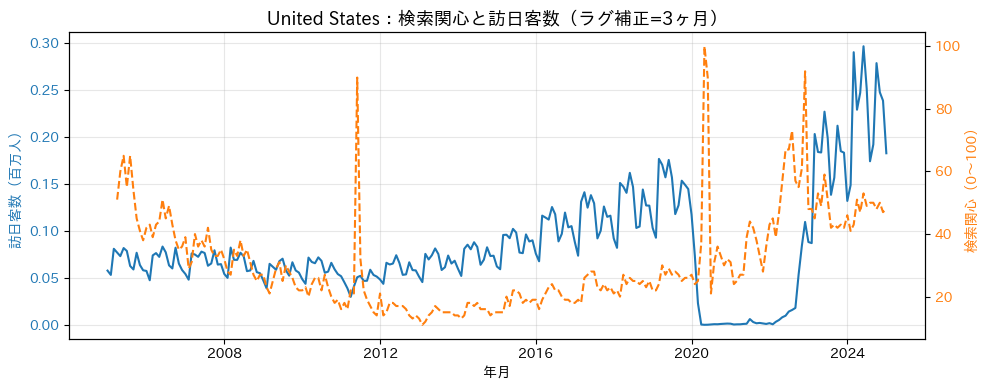

Thailand: lag=1


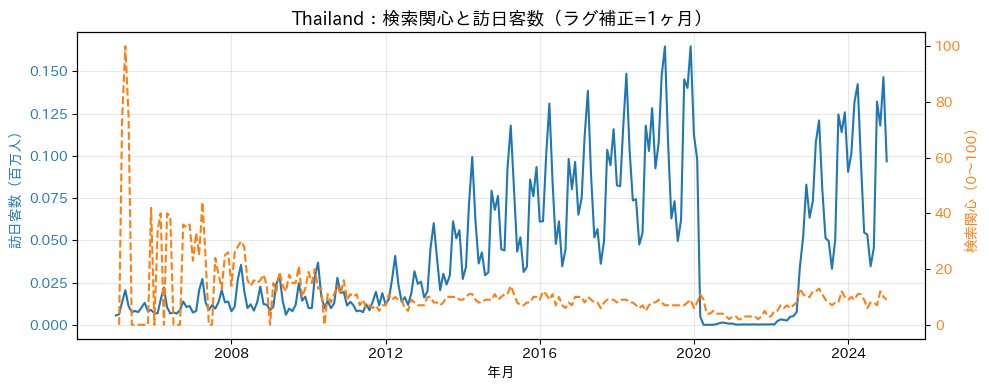

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# ===== データ読み込み =====
vis = pd.read_csv("../data/merged/merged_trends_visitors.csv")
lagcorr = pd.read_csv("../data/outputs/heatmaps_yearly/lagcorr_2018_2025.csv")

# 日付→年列を追加
vis["date"] = pd.to_datetime(vis["date"])
vis["Year"] = vis["date"].dt.year

# ===== 結合 =====
merged = pd.merge(vis, lagcorr, on=["Year", "Country"], how="left")

# ===== ラグごとの代表値抽出（最大相関のみ）=====
# NaNを除外した安全な処理
valid_lagcorr = lagcorr.dropna(subset=["Correlation"]).reset_index(drop=True)

top_lags = (
    valid_lagcorr.loc[
        valid_lagcorr.groupby(["Year", "Country"])["Correlation"].idxmax()
    ]
    .reset_index(drop=True)
)

# ===== 実測データ × 最大相関ラグの組み合わせ =====
merged_top = pd.merge(vis, top_lags, on=["Year", "Country"], how="left")

print(merged_top.head())

# === 可視化設定 ===
target_countries = ["South Korea", "China", "Taiwan", "Hong Kong", "United States", "Thailand"]

plt.figure(figsize=(12, 6))

for country in target_countries:
    # --- データ抽出 ---
    sub = merged_top[merged_top["Country"] == country].copy()
    if sub.empty:
        continue

    # 最新年のラグ（または平均ラグ）を取得
    lag_val = int(sub["Lag"].dropna().median()) if sub["Lag"].notna().any() else 0
    print(f"{country}: lag={lag_val}")

    # trend_interest をラグ補正
    sub = sub.sort_values("date")
    sub["trend_shifted"] = sub["trend_interest"].shift(lag_val)

    # --- グラフ ---
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()

    ax1.plot(sub["date"], sub["Visitor_Arrivals"] / 1e6, color="tab:blue", label="訪日客数（百万人）")
    ax2.plot(sub["date"], sub["trend_shifted"], color="tab:orange", linestyle="--", label="検索関心（ラグ補正）")

    # === 軸・装飾 ===
    ax1.set_title(f"{country}：検索関心と訪日客数（ラグ補正={lag_val}ヶ月）", fontsize=13)
    ax1.set_xlabel("年月")
    ax1.set_ylabel("訪日客数（百万人）", color="tab:blue")
    ax2.set_ylabel("検索関心（0〜100）", color="tab:orange")

    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax1.grid(alpha=0.3)
    fig.tight_layout()
    plt.show()

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

# ===== ディレクトリ設定 =====
SAVE_DIR = "../data/outputs/lag_shift_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# ===== 対象範囲 =====
YEARS = range(2018, 2026)
COUNTRIES = ["South Korea", "China", "Taiwan", "Hong Kong", "United States", "Thailand"]

# ===== グラフ出力ループ =====
for year in YEARS:
    for country in COUNTRIES:
        sub = merged_top[(merged_top["Country"] == country) & (merged_top["Year"] == year)]
        if sub.empty:
            print(f"⚠️ {country} {year}: データなし")
            continue

        lag = int(sub["Lag"].iloc[0]) if not pd.isna(sub["Lag"].iloc[0]) else 0

        sub_year = sub.set_index("date").asfreq("MS")

        # ===== グラフ作成 =====
        plt.figure(figsize=(10, 4))
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # 元データ
        ax1.plot(sub_year.index, sub_year["Visitor_Arrivals"]/1e6, color="tab:blue", label="訪日客数（百万人）")
        ax2.plot(sub_year.index, sub_year["trend_interest"], color="tab:orange", linestyle="--", label="検索関心（元データ）")

        # ラグ補正後データ
        ax2.plot(sub_year.index, sub_year["trend_interest"].shift(lag), color="tab:red", linewidth=1.8,
                 label=f"検索関心（ラグ補正={lag:+}ヶ月）")

        ax1.set_title(f"{country} {year}年：検索関心と訪日客数（ラグ補正={lag:+}ヶ月）", fontsize=12)
        ax1.set_xlabel("月")
        ax1.set_ylabel("訪日客数（百万人）", color="tab:blue")
        ax2.set_ylabel("検索関心（0〜100）", color="tab:red")

        # X軸の月表示を調整
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m月"))
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        ax1.tick_params(axis="y", labelcolor="tab:blue")
        ax2.tick_params(axis="y", labelcolor="tab:red")
        ax1.grid(alpha=0.3)

        # 凡例
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")

        plt.tight_layout()

        # ===== 保存 =====
        filename = f"{country}_{year}_lag{lag:+}.png"
        plt.savefig(os.path.join(SAVE_DIR, filename), dpi=200)
        plt.close()

        print(f"✅ {country} {year}: 完了（ラグ={lag:+}ヶ月）")

print("🎉 全地域・全年度のラグ補正グラフを生成完了！")

✅ South Korea 2018: 完了（ラグ=-5ヶ月）
✅ China 2018: 完了（ラグ=+1ヶ月）
✅ Taiwan 2018: 完了（ラグ=-5ヶ月）
✅ Hong Kong 2018: 完了（ラグ=+4ヶ月）
✅ United States 2018: 完了（ラグ=+3ヶ月）
✅ Thailand 2018: 完了（ラグ=-1ヶ月）
✅ South Korea 2019: 完了（ラグ=-3ヶ月）
✅ China 2019: 完了（ラグ=+6ヶ月）
✅ Taiwan 2019: 完了（ラグ=+5ヶ月）
✅ Hong Kong 2019: 完了（ラグ=+2ヶ月）
✅ United States 2019: 完了（ラグ=+2ヶ月）
✅ Thailand 2019: 完了（ラグ=+2ヶ月）
✅ South Korea 2020: 完了（ラグ=-1ヶ月）
✅ China 2020: 完了（ラグ=-1ヶ月）
✅ Taiwan 2020: 完了（ラグ=-1ヶ月）
✅ Hong Kong 2020: 完了（ラグ=-1ヶ月）
✅ United States 2020: 完了（ラグ=-1ヶ月）
✅ Thailand 2020: 完了（ラグ=-1ヶ月）
✅ South Korea 2021: 完了（ラグ=+6ヶ月）
✅ China 2021: 完了（ラグ=+0ヶ月）
✅ Taiwan 2021: 完了（ラグ=+6ヶ月）
✅ Hong Kong 2021: 完了（ラグ=+3ヶ月）
✅ United States 2021: 完了（ラグ=+3ヶ月）
✅ Thailand 2021: 完了（ラグ=+1ヶ月）
✅ South Korea 2022: 完了（ラグ=+6ヶ月）
✅ China 2022: 完了（ラグ=+1ヶ月）
✅ Taiwan 2022: 完了（ラグ=+2ヶ月）
✅ Hong Kong 2022: 完了（ラグ=-5ヶ月）
✅ United States 2022: 完了（ラグ=+3ヶ月）
✅ Thailand 2022: 完了（ラグ=+3ヶ月）
✅ South Korea 2023: 完了（ラグ=+3ヶ月）
✅ China 2023: 完了（ラグ=-2ヶ月）
✅ Taiwan 2023: 完了（ラグ=-3ヶ月）
✅ Hong Kong 2023: 完了（ラグ=-

In [25]:
import pandas as pd

lagcorr = pd.read_csv("../data/outputs/heatmaps_yearly/lagcorr_2018_2025.csv")

# 各年・各国で最も強い相関ラグを抽出
valid_lagcorr = lagcorr.dropna(subset=["Correlation"]).reset_index(drop=True)

best_lags = (
    valid_lagcorr.loc[valid_lagcorr.groupby(["Year", "Country"])["Correlation"].idxmax()]
    .reset_index(drop=True)
)
print(best_lags.head())

       Country  Lag  Correlation  Year
0        China    1     0.385353  2018
1    Hong Kong    4     0.405149  2018
2  South Korea   -5     0.449020  2018
3       Taiwan   -5     0.660909  2018
4     Thailand   -1     0.523537  2018
